# BechdelAI tutorial #4 - Analyzing gender representation in posters with Computer Vision

> **Objective of the tutorial**: Description: In this tutorial, we'll use Computer Vision to analyze the gender representation in movie pictures. We'll focus on the movie "Triangle of Sadness" and follow these steps:
> 1. Get all pictures (backdrops and posters) for the movie from the TMDb API.
> 2. Use a face detection algorithm to extract the locations of faces in the posters.
> 3. Use a gender classification algorithm to guess the genders of the people in the posters.
> 4. Use a question-answering algorithm to ask questions about body representation or any other question we may have about the movie posters.
> 
> By the end of this tutorial, you'll have learned how to use Computer Vision to analyze gender representation in movie pictures and how to use different algorithms to detect faces, guess genders, and ask questions about images.

In [54]:
# Classical imports 
import pandas as pd
import numpy as np

In [3]:
# For developers who want to use the latest development version or the library locally
# Use poetry to install dependencies
import sys
sys.path.append("../") # Or change to the folder to the direction of the working directory

%load_ext autoreload
%autoreload 2

import bechdelai

# Analyze a movie poster or image

## Let's select a movie
We will analyze the movie *Triangle of Sadness* - a 2022 satirical black comedy film written and directed by Ruben Östlund in his English-language feature film debut. The film follows a celebrity couple on a luxury cruise with wealthy guests.Triangle of Sadness had its world premiere at the 2022 Cannes Film Festival on 21 May 2022, where it received an eight-minute standing ovation and won the Palme d'Or.

We will use the TMDB API wrapper to fetch movie information. Look at tutorial #3 to better understand how to use it. 

In [5]:
from bechdelai.data.tmdb import TMDB
tmdb = TMDB()

In [7]:
search = tmdb.search_movie_from_query("triangle of sadness")
search.iloc[0]

... There are 1 movies with 1 pages of results for the search 'triangle of sadness'


adult                                                            False
backdrop_path                         /pEwyF5rdnNqdesnZIADMZSd8peQ.jpg
genre_ids                                                     [35, 18]
id                                                              497828
original_language                                                   en
original_title                                     Triangle of Sadness
overview             A celebrity model couple are invited on a luxu...
popularity                                                      91.788
poster_path                           /jXHmT914ACC81F1Dy57hsesuoYj.jpg
release_date                                                2022-09-23
title                                              Triangle of Sadness
video                                                            False
vote_average                                                     7.342
vote_count                                                         765
Name: 

In [8]:
movie_id = search.iloc[0]["id"]
metadata = tmdb.get_movie_details(movie_id)
images = tmdb.get_movie_images(movie_id)
cast,crew = tmdb.get_movie_cast(movie_id)

## Visualizing the images

In the images dataframe we get all backdrops images (promotional images and clips from the movie) and posters. We can filter by size, language, or by image type. For this movie we have 100+ pictures we can use. 

In [26]:
images

,aspect_ratio,height,iso_639_1,file_path,vote_average,vote_count,width,image_type
0,1.778,1440,None,/pEwyF5rdnNqdesnZIADMZSd8peQ.jpg,5.384,2,2560,backdrop
1,1.778,2160,None,/vNPY4oCSUp7CxbHkKJNRx1fmCl0.jpg,5.318,3,3840,backdrop
2,1.778,720,fr,/bCDx9j8OO7K1CApqPC8fX5E9LVH.jpg,5.312,1,1280,backdrop
3,1.778,2160,None,/6RhLu6bSEpLDndfx723XdBMyspu.jpg,5.312,1,3840,backdrop
4,1.778,2160,en,/AiX08q3WFgNtUVf0KjMQZ01PMAb.jpg,5.312,1,3840,backdrop
...,...,...,...,...,...,...,...,...
100,0.706,1080,en,/yXDKFFBvpcICcXg9uIEOWMd6DRT.jpg,0.000,0,763,poster
101,0.667,1500,en,/4RdOQHKflxkeIqtAMEjSShKAGLe.jpg,0.000,0,1000,poster
102,0.675,1280,en,/bGNzUci8KZs79dNWlcX2imigYvv.jpg,0.000,0,864,poster
103,0.700,1000,es,/9zKTjrNHM5dYcy0r94QZ463h7Md.jpg,0.000,0,700,poster


We can use an helper function to easily visualize in a notebook a gallery of images. We instantly see what images have been been used for the promotion of the movie. 

In [25]:
tmdb.show_images_on_notebook(images["file_path"].tolist()[:9])

In [39]:
tmdb.show_images_on_notebook(images.query("image_type=='backdrop'")["file_path"].tolist(),width = 100)

In [36]:
# Let's look for all posters in French and English
posters = images.query("image_type == 'poster'").query("iso_639_1=='fr'")
print(posters.shape)

tmdb.show_images_on_notebook(posters["file_path"].tolist(),width = 100)

(7, 8)


# Analyze gender representation on posters

We will start by analyzing the two most different posters

In [40]:
paths = [
    "/xDwMX7mI7m4t4rLNenuaAeGPmgt.jpg",
    "/r6i19y9p08YBnZHUbJPODAg0XII.jpg",
]
tmdb.show_images_on_notebook(paths,width = 200)

To download the images to be used in the notebook, you can use the following function (``.get_image_from_url()`` works as well), which retrieves the images as PIL Image and download them in the current working directory.

In [48]:
poster1,poster2 = tmdb.download_image(paths)

... Images saved in current working directory


To analze the image, we will need to use the Computer Vision tools developed in the library ``bechdelai``. They use a combination of classical Computer Vision algorithms such as OpenCV with modern deep learning frameworks like CLIP.

In [127]:
from bechdelai.image.face_detection import FacesDetector
from bechdelai.image.gender_detection import GenderDetector
from bechdelai.image.vilt import ViLT
from bechdelai.image.clip import CLIP

Gender detection works with the CLIP model used with zero-shot learning. Internal research has shown the BechdelAI team that the gender detection was a lot more accurate using zero-shot learning on modern Neural Network pre-trained model such as CLIP, than using the existing pre-trained model (like the ones in DeepFace, that is only a VGG-Face). 

The CLIP model is retrieved from the Hugging Face hub https://huggingface.co/docs/transformers/model_doc/clip. The first time it will download the model and cache it to be faster the next time. 

In [44]:
fd = FacesDetector()
gd = GenderDetector()

Loading CLIP model


## Analyze faces on first poster

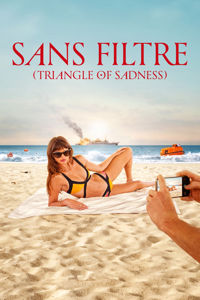

In [81]:
poster1.resize((200,300))

To detect faces we will use the Retina Face algorithm. It's by far the most accurate, but takes more time for detection (especially on CPU)

In [82]:
rois,faces = fd.detect(np.array(poster1),method = "retinaface",padding = 20)

In [83]:
faces

[<PIL.Image.Image image mode=RGB size=192x216 at 0x265938B30D0>]

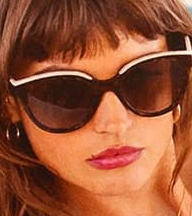

In [84]:
faces[0]

It gives the Region Of Interests (ROIs) which means the boundaries of the faces detected

In [85]:
rois

{'face_1': {'score': 0.997473418712616,
  'facial_area': [537, 1466, 689, 1642],
  'landmarks': {'right_eye': [585.4439, 1543.0669],
   'left_eye': [656.9468, 1528.677],
   'nose': [635.4172, 1576.2346],
   'mouth_right': [607.485, 1606.47],
   'mouth_left': [663.67523, 1595.1409]}}}

Now we will input the faces detected to the gender detector. It predicts the correct gender accurately, also gives out the probabilities and the area occupied by the face in the poster. This metric can be used later to understand not only if women are present but also the space they occupy compared to men. 

In [86]:
probas = gd.predict(faces)
probas

,man,woman,diff,gender,area,area_percentage_relative
0,0.016918,0.983082,0.966163,woman,41472,1.0


We can visualize the faces directly on the poster

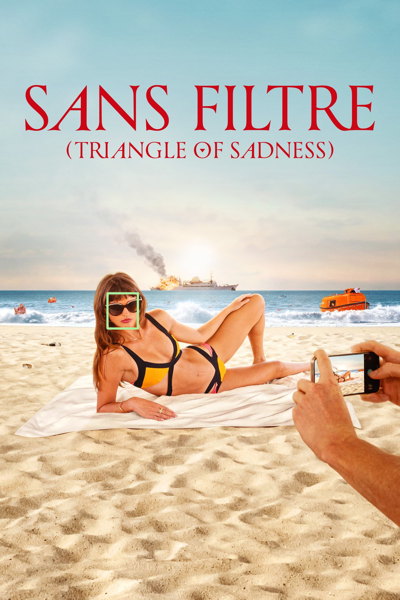

In [87]:
from bechdelai.image.utils import show_faces_on_image,show_all_faces

img_with_faces = show_faces_on_image(poster1,rois,width = 10,genders = probas["gender"])
img_with_faces.resize((400,600))

## Analyzing faces on second poster

The second poster will be much harder to represent

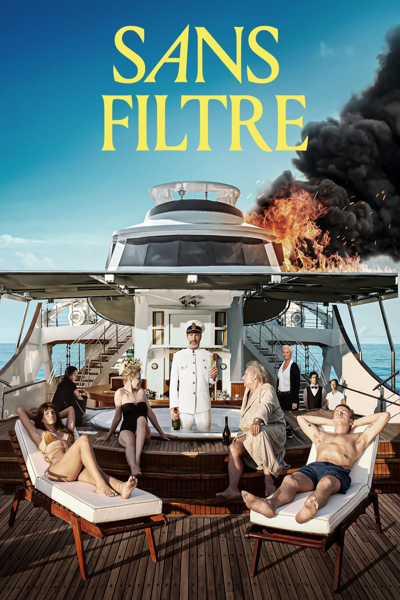

In [88]:
poster2.resize((400,600))

In [101]:
rois,faces = fd.detect(np.array(poster2),method = "retinaface",padding = 20)
probas = gd.predict(faces)

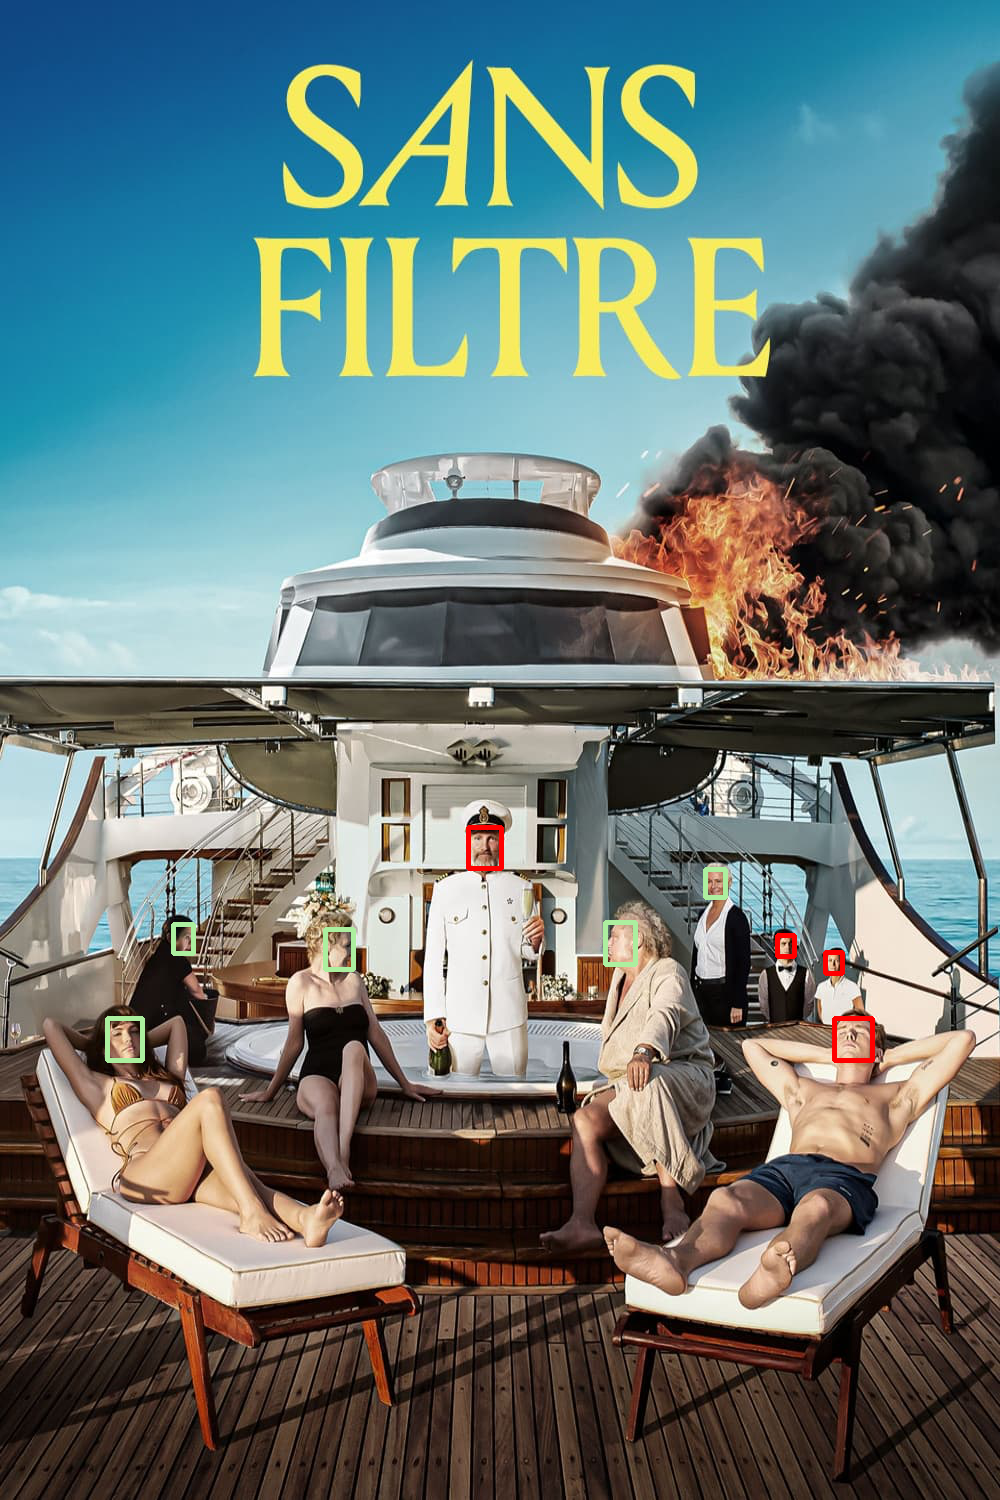

In [102]:
img_with_faces = show_faces_on_image(poster2,rois,width = 3,genders = probas["gender"])
img_with_faces

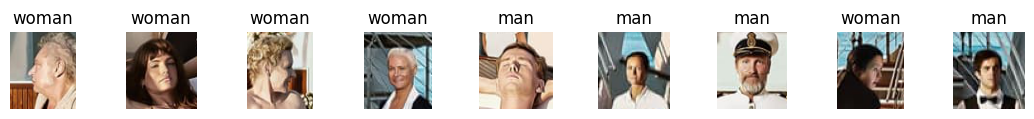

In [103]:
show_all_faces(faces,titles = probas["gender"])

In [106]:
probas

,man,woman,diff,gender,area,area_percentage_relative
0,0.584204,0.415796,0.168407,woman,5740,0.128088
1,0.090330,0.909670,0.819341,woman,6150,0.137237
2,0.047753,0.952247,0.904493,woman,5440,0.121393
3,0.052877,0.947123,0.894245,woman,4080,0.091045
4,0.920718,0.079282,0.841437,man,6396,0.142726
5,0.882628,0.117372,0.765255,man,3477,0.077589
6,0.983872,0.016128,0.967744,man,5913,0.131948
7,0.288949,0.711051,0.422101,woman,4140,0.092384
8,0.913412,0.086588,0.826823,man,3477,0.077589


We see here that the detector is correct on most faces, a bit less accurate for the people from the side or far in the background. Let's correct manually the incorrect ones (in a future release we may build an interactive editor). 

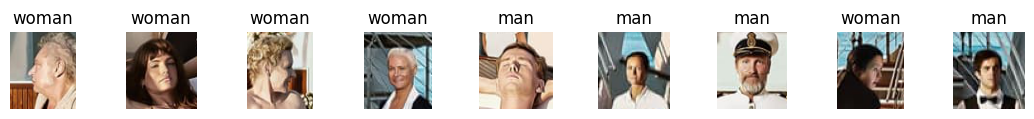

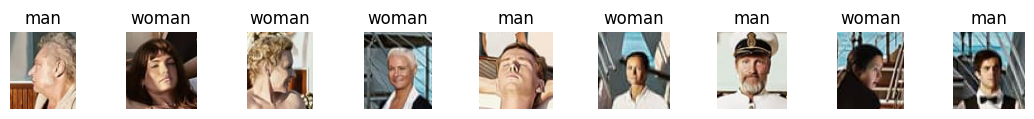

In [108]:
probas["gender_corrected"] = probas["gender"]
probas.loc[0,"gender_corrected"] = "man"
probas.loc[5,"gender_corrected"] = "woman"

show_all_faces(faces,titles = probas["gender"])
show_all_faces(faces,titles = probas["gender_corrected"])

Now that we have the results, we can compute some statistics using the ``.analyze_probas()`` function. It computes the following metrics : 
- Number of men and women
- Over/under representation by count
- Over/under representation by space occupied on the image

In [112]:
results,metrics = gd.analyze_probas(probas)
metrics

{'women_area': 0.5701470555419187,
 'men_area': 0.42985294445808137,
 'n_women': 5,
 'n_men': 4,
 'ratio_count': '1.2x 👩',
 'ratio_area': '1.3x 👩',
 'n_characters': 9,
 'area_gap': 1.3263769921611381,
 'count_gap': 1.25}

## Visual Question Answering (VQA) with ViLT and CLIP

Counting characters genders and space are not enough to understand women representation in an image. We can go further using zero-shot learning models ViLT and CLIP. 

### ViLT
We ViLT you can directly ask questions to an image
https://huggingface.co/dandelin/vilt-b32-finetuned-vqa. Like other HuggingFace models the first time it make time to load. 

In [114]:
vilt = ViLT()

Loading ViLT model


In [122]:
questions = [
    "How many women are in the picture?",
    "Where is the woman?",
    "What is the woman doing?",
    "What is the woman wearing?",
    "What color is her bikini?",
    "Is the woman undressed?",
]
preds,probas = vilt.predict(np.array(poster1),questions)

In [126]:
for i,question in enumerate(questions):
    print("-"*50)
    print(question)
    print(preds[i])

--------------------------------------------------
How many women are in the picture?
   rank answer     proba
0     0      1  0.998586
1     1      2  0.000970
2     2      3  0.000151
3     3      0  0.000115
4     4    yes  0.000071
--------------------------------------------------
Where is the woman?
   rank    answer     proba
0     0     beach  0.977864
1     1  on beach  0.017526
2     2      sand  0.000324
3     3     ocean  0.000295
4     4       bed  0.000263
--------------------------------------------------
What is the woman doing?
   rank       answer     proba
0     0      sitting  0.248004
1     1     relaxing  0.174370
2     2  laying down  0.137129
3     3   sunbathing  0.071967
4     4       posing  0.071885
--------------------------------------------------
What is the woman wearing?
   rank        answer     proba
0     0        bikini  0.971361
1     1      swimsuit  0.014409
2     2  bathing suit  0.004070
3     3      tank top  0.001754
4     4           yes  0.

### CLIP
CLIP can be used to directly label a picture among possible tags. As it's zero shot learning, you can chose whatever useful text description. 

In [134]:
clip = CLIP()
clip.set_prompts({
    "gender count":["one woman","two woman","one man","two man"],
})

Loading CLIP model


In [135]:
preds,probas = clip.predict(poster1)

In [136]:
probas

,one woman,two woman,one man,two man
0,0.605491,0.172327,0.198686,0.023496


# Next steps

We've seen how to use computer vision on a single image in this tutorial to study gender representation. It can be used to analyze any picture, poster or frame from a movie. If you want to experiment, you can : 
- Apply those techniques to a set a posters
- Compare the results to the Bechdel test results
- Use ViLT to understand body representation on pictures

In the next tutorials, we will see how to apply those algorithms to a video.